### How to run GP classification

We simply change the likelihood.

In [ ]:
!pip install git+ssh://git@github.com/UncertaintyInComplexSystems/bayesianmodels.git
!pip install numpy==1.23.5

In [7]:
import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes
config.update("jax_default_device", jax.devices()[0])

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gpmodels.fullgpmodels import FullLatentGPModel, FullMarginalGPModel
from uicsmodels.gpmodels.likelihoods import inv_probit, Bernoulli

Simulate some data from a known GP with a Bernoulli likelihood and an inverse probit link function:

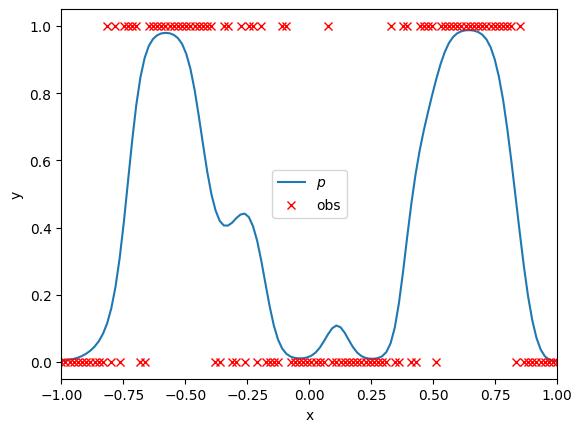

In [69]:
key = jrnd.PRNGKey(1234)

lengthscale_ = 0.15
variance_ = 10.0
n = 120
x = jnp.linspace(-1, 1, n)[:, jnp.newaxis]

kernel = jk.RBF()
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=variance_),
                            x=x, y=x) + 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
key, key_f = jrnd.split(key)
z = jrnd.normal(key_f, shape=(n,))

f_true = jnp.dot(L, z)
p_true = inv_probit(f_true)
key, key_obs = jrnd.split(key)
y = jrnd.bernoulli(key, p=p_true)

ground_truth = dict(f=f_true,
                    p=p_true,
                    lengthscale=lengthscale_,
                    variance=variance_)

plt.figure(figsize=(12, 4))
plt.plot(x, p_true, label=r'$p$')
plt.plot(x, y, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1., 1.])
plt.legend(loc='best');

Set up the model and perform inference (note that we cannot marginalize $\mathbf{f}$ this time):

In [71]:
%%time
priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp())))

gp_binary = FullLatentGPModel(x, y,
                          cov_fn=jk.RBF(),
                          likelihood=Bernoulli(),
                          priors=priors)

key = jrnd.PRNGKey(8642)
particles, num_iter, marginal_likelihood = gp_binary.inference(key,
                                                               mode='smc',
                                                               sampling_parameters=dict(num_particles=1_000, num_mcmc_steps=100))

CPU times: user 16 s, sys: 69.5 ms, total: 16.1 s
Wall time: 16.6 s


Plot posterior:

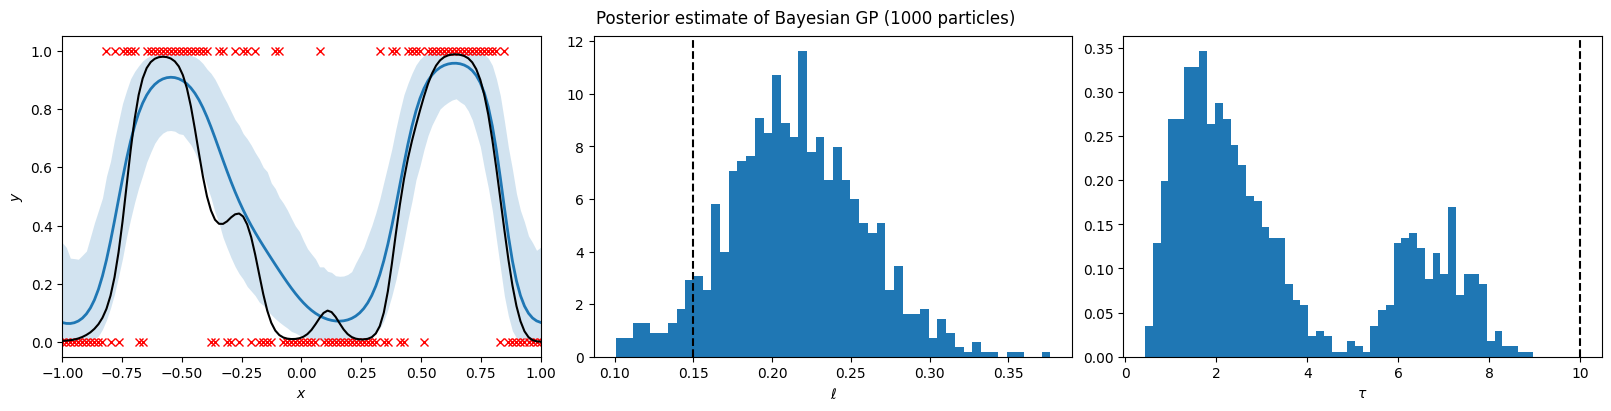

In [79]:
key, key_pred = jrnd.split(key)

trainables = list()
for component, val in priors.items():
    trainables.extend(list(val.keys()))

num_particles = particles.particles['f'].shape[0]

num_params = len(trainables)
show_samples = jnp.array([int(i) for i in num_particles*jnp.linspace(0, 1, num=500)])

symbols = dict(lengthscale='\ell',
               obs_noise='\sigma',
               variance=r'\tau',
               constant='c')

_, axes = plt.subplots(nrows=1, ncols=1+num_params, constrained_layout=True, figsize=(16, 4))
ax = axes[0]
f_pred = gp_binary.predict_f(key_pred, x)
p_pred = jax.vmap(inv_probit)(f_pred)
p_mean = jnp.mean(p_pred, axis=0)
p_hdi_lower = jnp.percentile(p_pred, q=2.5, axis=0)
p_hdi_upper = jnp.percentile(p_pred, q=97.5, axis=0)

ax.plot(x, p_mean, color='tab:blue', lw=2)
ax.fill_between(x.flatten(), p_hdi_lower, p_hdi_upper,
                alpha=0.2, color='tab:blue', lw=0)
ax.plot(x, y, 'rx')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim([-1, 1])

for j, var in enumerate(trainables):
    ax = axes[j+1]
    pd = particles.particles[var]
    # There are some outliers that skew the axis
    pd_u, pd_l = jnp.percentile(pd, q=99.9), jnp.percentile(pd, q=0.1)
    pd_filtered = jnp.extract(pd>pd_l, pd)
    pd_filtered = jnp.extract(pd_filtered<pd_u, pd_filtered)
    ax.hist(pd_filtered, bins=50, density=True, color='tab:blue')
    if var in symbols:
        ax.set_xlabel(r'${:s}$'.format(symbols[var]))

plt.suptitle(f'Posterior estimate of Bayesian GP ({num_particles} particles)');


if len(ground_truth):
    axes[0].plot(x, ground_truth['p'], 'k')
    for j, var in enumerate(trainables):
        axes[j+1].axvline(x=ground_truth[var], ls='--', c='k');